In [1]:
import torch
import numpy as np
import pickle
from scipy.stats import sem
from matplotlib.colors import ListedColormap


# grammar
from return_types import *
from data import *
from utils import *
from renderer import derender, render

# likelihood
from mcmc import mcmc_sampler, imaginary_mcmc_sampler


# plotting

import matplotlib.pyplot as plt
import pylab
from plot_utils import plot_params, plot_bitmask, plot_ll
pylab.rcParams.update(plot_params)

## Load Codebook Example

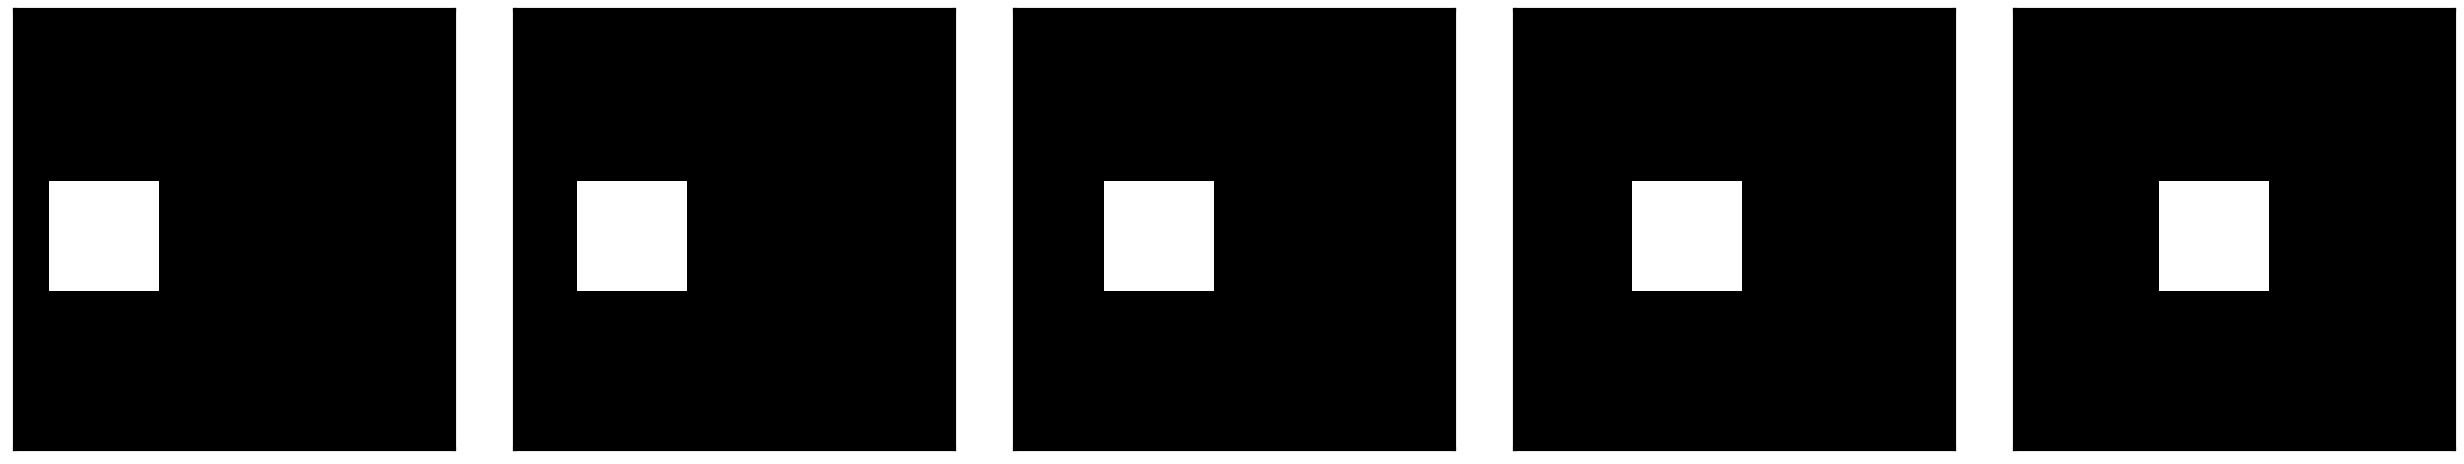

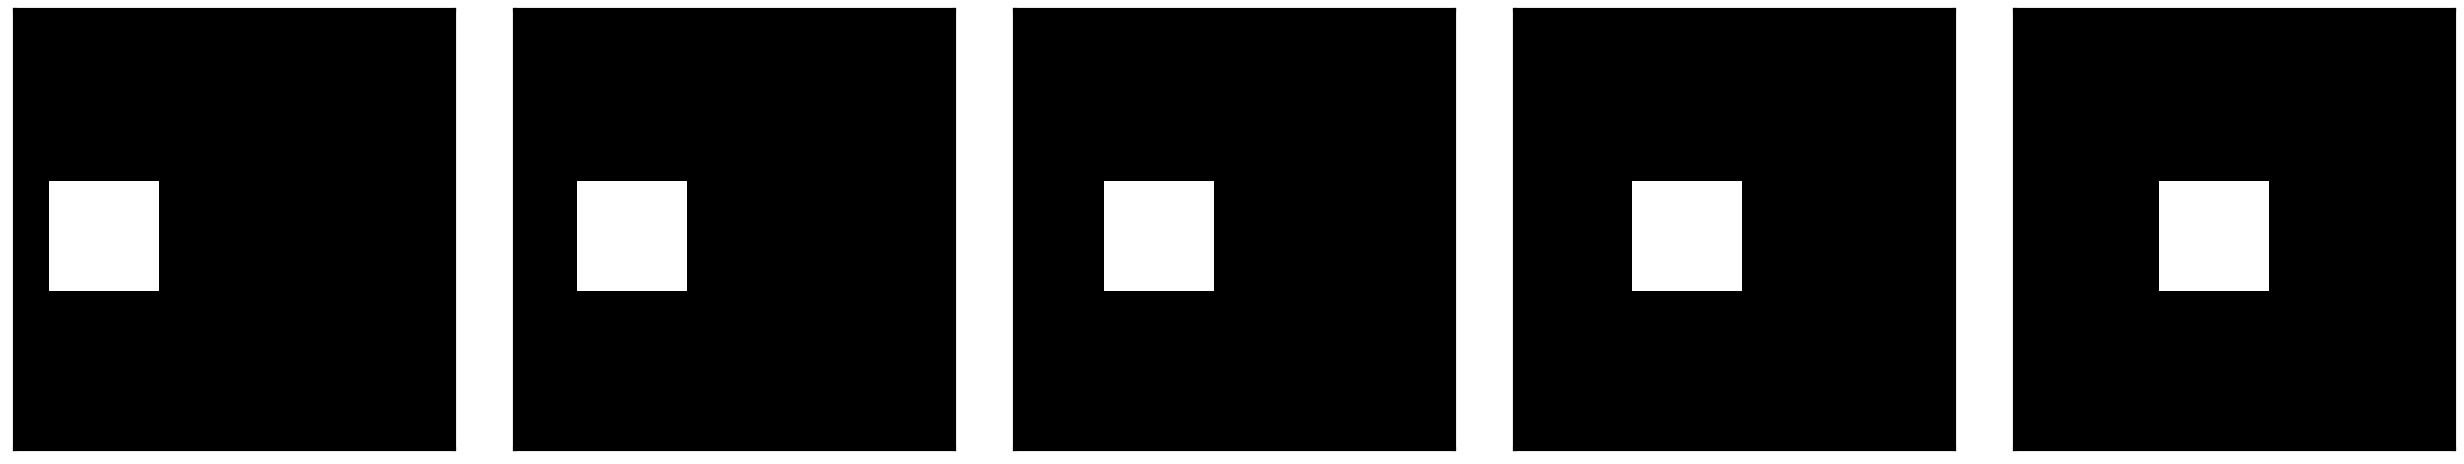

In [2]:
world = 1
timesteps = 5

Codebooks = DataObject(root_dir='../codebooks/' + str(world) + '/codes_', timesteps=timesteps) 

Masks = derender(Codebooks)
Codebooks._plot_codebooks(timesteps, figsizes=(5 * timesteps, 5)) 

## Get Sim Results

In [10]:

continuity = [1, 2]
rigidity = [5, 6, 7]
permanence = [3, 4]
unchangeableness = [8]

curr_world = permanence
curr_world_str = 'permanence'

mcmc_steps = [10, 100, 1000, 5000]
n_runs = 100

plot_res = {w: {'ll_error': [], 'll': [], 'n_objects': [], 'n_objects_error': [], 'bitmasks': []} for w in curr_world}

for w in curr_world:
    for steps in mcmc_steps:
        file_name = f'sim_res/{w}_mcmc_{steps}_ebby.pkl'
        with open(file_name, 'rb') as f:
            data = pickle.load(f)
    
        n_objects = [data[0][j][-1] for j in range(n_runs) if data[0][j] != []] # number of objects
        avg_n_objects = np.mean(n_objects)
        sem_n_objects = 1.95 * sem(n_objects)
        plot_res[w]['n_objects'].append(avg_n_objects)
        plot_res[w]['n_objects_error'].append(sem_n_objects)
        likelihoods = np.array([data[1][j][-1][0] for j in range(n_runs) if data[1][j] != []])# likelihoods 
        if w == 7:
            print(likelihoods)
        avg_likelihood = np.mean(likelihoods)
        sem_likelihood = 1.95 * sem(likelihoods)
        plot_res[w]['ll'].append(avg_likelihood)
        plot_res[w]['ll_error'].append(sem_likelihood)
        bitmasks = [data[2][j][-1] for j in range(n_runs) if data[2][j] != []]
        plot_res[w]['bitmasks'].append(bitmasks)
print(plot_res)

{3: {'ll_error': [21.14384650221172, 14.19856510916124, 1.7393093208156316, 2.127272727272728], 'll': [-343.36, -145.89, -19.181818181818183, -19.09090909090909], 'n_objects': [1.97, 1.95, 2.0, 2.0], 'n_objects_error': [0.07041742423834911, 0.06425711845957048, 0.0, 0.0], 'bitmasks': [[<return_types.Bitmask object at 0x1037a8d00>, <return_types.Bitmask object at 0x15071bfa0>, <return_types.Bitmask object at 0x15070acd0>, <return_types.Bitmask object at 0x15074bc10>, <return_types.Bitmask object at 0x150746f10>, <return_types.Bitmask object at 0x150929e20>, <return_types.Bitmask object at 0x15075e790>, <return_types.Bitmask object at 0x15007e400>, <return_types.Bitmask object at 0x150777820>, <return_types.Bitmask object at 0x150799f10>, <return_types.Bitmask object at 0x1507938e0>, <return_types.Bitmask object at 0x150777d30>, <return_types.Bitmask object at 0x1507a4820>, <return_types.Bitmask object at 0x1507728e0>, <return_types.Bitmask object at 0x150793820>, <return_types.Bitmask o

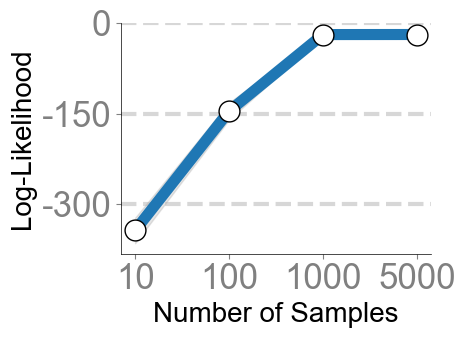

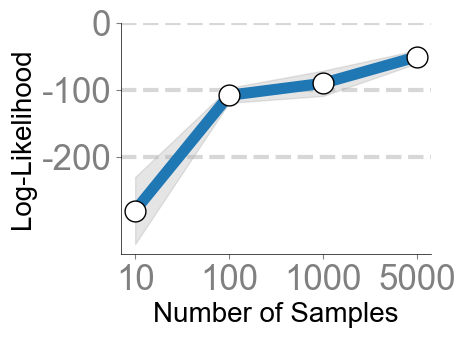

In [11]:
import math
# Define color and linestyle options
labels = {"rigidity" :[r'move-both', r'move-small', r'move-large'], 
          "permanence": [r'move-persist', r'move-disappear'], 
          "continuity": [r'move-simple', r'melt', ], 
          "unchangeableness": [r'no-change']}

def round_to_nearest_hundred(num):
    return math.ceil(num/100)*100

for i, world in enumerate(curr_world):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
    plt.rcParams.update({'font.size': 10})  

    x = [1, 2, 3, 4]
    y = plot_res[world]['ll']
    err = plot_res[world]['ll_error']

    # ax = axs[i]
    ax.set_xticks([1, 2, 3, 4])
    
    line, = ax.plot(x, y, label=labels[curr_world_str][i], linewidth=8, marker='o', markersize=15, markerfacecolor='white', markeredgecolor='black')
    ax.fill_between(x, np.subtract(y, err), np.add(y, err), alpha=0.2, color='grey')
    ax.set_xlabel(r'Number of Samples', fontsize=20)
    ax.set_ylabel(r'Log-Likelihood', fontsize=20)

    ax.grid(True, axis='y', linestyle='--', linewidth=3, alpha=0.5)
    ax.tick_params(axis='both', which='both', labelsize=25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    ax.set_xticklabels(['10', '100', '1000', '5000'], fontsize=25)

    y_min = min(y)
    yticks = np.linspace(0, round_to_nearest_hundred(y_min), 3)
    ax.set_yticks(yticks)
    yticklabels = [int(np.ceil(y)) for y in yticks]
    ax.set_yticklabels(yticklabels)
    
    # fig.savefig(f'fig/ll_{curr_world_str}_{i}.pdf', bbox_inches='tight')
    plt.show()


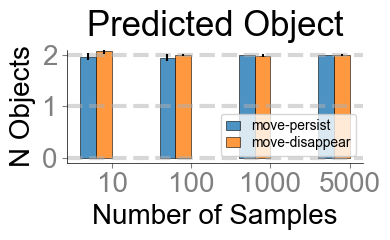

In [12]:
n_samples = [10, 100, 1000, 5000]
n_objects = [plot_res[w]['n_objects'] for w in curr_world]
n_objects_error = [plot_res[w]['n_objects_error'] for w in curr_world]

# Figure setup
fig, ax = plt.subplots(figsize=(4, 2.5))
plt.rcParams.update({'font.size': 10})

# Plot bars
bar_width = 0.2
opacity = 0.8


for i in range(len(n_objects)):
    error = n_objects_error[i]
    rects = ax.bar(np.arange(len(n_samples)) + i * bar_width, n_objects[i], bar_width, 
                   alpha=opacity, edgecolor='black', linewidth=0.5, yerr=error, 
                   capsize=0, label=labels[curr_world_str][i])

# Axes labels and ticks
ax.set_title("Predicted Object", fontsize=25, pad=10)
ax.set_xlabel(r'Number of Samples', fontsize=20)
ax.set_ylabel(r'N Objects', fontsize=20)
ax.set_xticks(np.arange(len(n_samples)) + bar_width * 1.5
              )
ax.set_xticklabels(n_samples, fontsize=20)
ax.set_ylim([-0.1, 2.1])
ax.set_yticks([0, 1, 2])
# Legend and title
legend = ax.legend(fontsize=10, loc='lower right', handlelength=1, labelspacing=0.2)

ax.tick_params(axis='both', which='both', labelsize=20)
# Grid and spine formatting
ax.grid(True, axis='y', linestyle='--', linewidth=3, alpha=0.5)
#  ax.tick_params(axis='both', which='both', labelsize=25)
# ax.tick_params(axis='both', which='both', length=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

# Save and show plot
fig.tight_layout()
# fig.savefig(f'fig/n_object_{curr_world_str}.pdf', bbox_inches='tight')
plt.show()


In [13]:
# compute average bitmask
def average_bitmask(bitmasks, n_repeat=100, object=0, world=4):
    average_bitmask = torch.zeros_like(bitmasks[0].bitmasks[:, object])
    # average_bitmask[:,0,0] = 1
    n_imaginary_win = 0
    for i, bitmask in enumerate(bitmasks):
        n_imaginary_win += 1/n_repeat
        average_bitmask[:] += bitmasks[i].bitmasks[:, object] / n_repeat
    if i < n_repeat - 1:
        
        timesteps = 10
        Codebooks = DataObject(root_dir='../codebooks/' + str(world) + '/codes_', timesteps=timesteps) 
        original_bitmask = derender(Codebooks)
        for j in range(n_repeat - i):
            average_bitmask[:] += original_bitmask.bitmasks[:, object] / n_repeat
    return average_bitmask, original_bitmask
# a = average_bitmask(bitmasks[1][1], object=1)[1]
# plt.imshow(a.bitmasks[0,1])


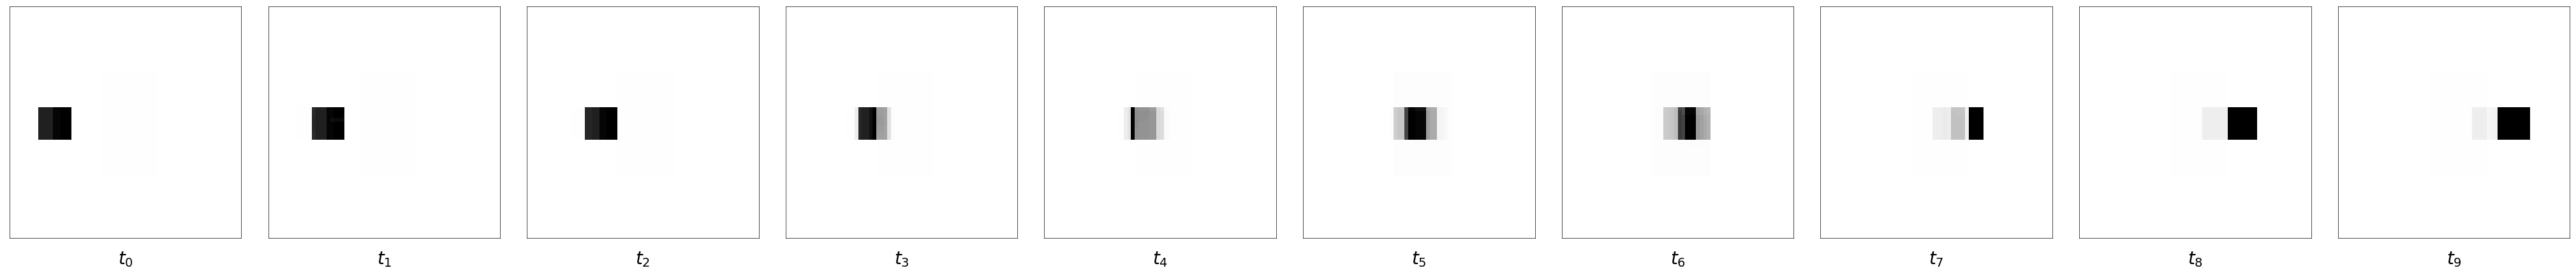

In [15]:
n_samples = [10, 100, 1000, 5000]
bitmasks = [plot_res[w]['bitmasks'] for w in curr_world]

timesteps = 10
# Figure setup
fig, ax = plt.subplots(1, timesteps, figsize=(40, 3))

cmap = plt.get_cmap('Greys_r')
new_cmap = cmap(np.linspace(0, 1, 100))

new_cmap = new_cmap[::-1]
new_cmap[:,-1] = np.linspace(0, 1, 100)
new_cmap = ListedColormap(new_cmap)


# Plot images using imshow
for i in range(timesteps):
    im = ax[i].imshow(average_bitmask(bitmasks[0][1], object=0)[0][i].detach().numpy(), cmap=new_cmap)
    ax[i].xaxis.labelpad=10
    ax[i].yaxis.labelpad=10
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].spines['top'].set_linewidth(0.5)
    ax[i].spines['right'].set_linewidth(0.5)
    ax[i].spines['bottom'].set_linewidth(0.5)
    ax[i].spines['left'].set_linewidth(0.5)
    ax[i].set_xlabel(fr'$t_{i}$', fontsize=20)

fig.tight_layout(pad=-4, w_pad=-2.0)
# fig.savefig(f'fig/heat_map_{10}_{curr_world_str}.pdf', bbox_inches='tight')
plt.show()